In [1]:
## Load required packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime

In [2]:
## define directory
dir_path = os.path.abspath('')
os.chdir('..')
from pyCiSSA.pycissa import cissa, group, cissa_outlier, build_groupings

In [3]:
## Read data file  (source is the Ministry of Economy of Spain.)
data = pd.read_excel(dir_path + r'/Hopelands_Data_20221106.xlsx')
print(data.head(5))
print(data.npID.unique())

                     sID  npID          SampleDate Value
0  Manawatu at Hopelands  NH4N 1989-09-27 10:33:00  0.01
1  Manawatu at Hopelands   DRP 1989-09-27 10:33:00  0.02
2  Manawatu at Hopelands   NO3 1989-09-27 10:33:00  1.15
3  Manawatu at Hopelands  CLAR 1989-09-27 10:33:00   0.8
4  Manawatu at Hopelands  NH4N 1989-10-11 10:20:00  0.04
['NH4N' 'DRP' 'NO3' 'CLAR' 'ECOLI' 'DO_Conc' 'SSC' 'MCI' 'ASPM' 'QMCI'
 'Chl_a' 'Dep_Sed' 'SIN']


In [4]:
## Choose parameter of interest
variable = 'NH4N'
filtered_data = data.loc[data['npID'] == variable].reset_index(drop=True)
print(filtered_data.head(5))

                     sID  npID          SampleDate Value
0  Manawatu at Hopelands  NH4N 1989-09-27 10:33:00  0.01
1  Manawatu at Hopelands  NH4N 1989-10-11 10:20:00  0.04
2  Manawatu at Hopelands  NH4N 1989-11-22 09:34:00  0.03
3  Manawatu at Hopelands  NH4N 1989-12-13 09:45:00  0.02
4  Manawatu at Hopelands  NH4N 1990-01-24 09:40:00  0.06


In [5]:
## fix the censored values
def remove_censoring(df,valuecolumn = 'Value', strings_to_replace = ['<','>']):
    '''
    Function to take a pandas dataframe and remove unwanted strings from the column.
    Useful for removing censoring...

    Parameters
    ----------
    df : pandas dataframe
        DESCRIPTION: Input pandas dataframe which contains column to remove strings from
    valuecolumn : string, optional
        DESCRIPTION: The default is 'value'. Column name in the dataframe which we want to remove the defined strings from
    strings_to_replace :  list, optional
        DESCRIPTION: The default is '['<','>']'. List of strings which we want to remove from the data   
        
    Returns
    -------
    df : pandas dataframe
        DESCRIPTION: Output pandas dataframe which contains a new column with the strings of interest removed
    '''

    
    #check valuecolumn is in the dataframe columns
    if not valuecolumn in list(df.columns):
        raise Exception(f'Column: {valuecolumn} not found in this dataframe')
    
    new_column = []
    #Iterate through dataframe values
    for value_n in df[valuecolumn]:
        string = ''
        #make value a string
        string = str(value_n)
        
        #replace unwanted characters 
        for str_i in strings_to_replace:
            string = string.replace(str_i, '')
        
        try: #try to append float value 
            new_column.append(float(string))
        except: #if making float fails, just append the original value    
            new_column.append(value_n)
    
    #Add new column to dataframe
    df['uncensored_value'] =   new_column
    return df       



uncensored_data = remove_censoring(filtered_data)


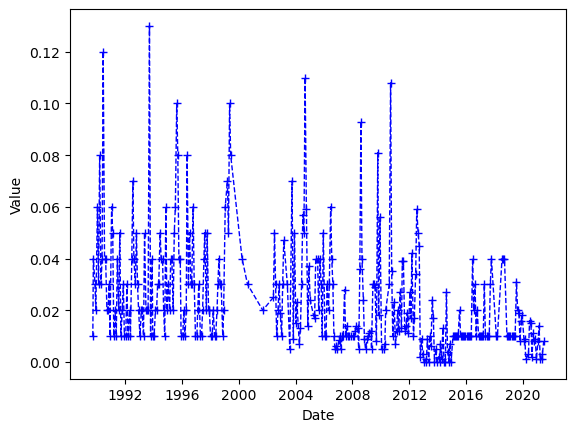

In [6]:
## Plot the data
plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--+', lw=1.0)
plt.ylabel('Value')
plt.xlabel('Date')
plt.show()

In [7]:
## Add in year and month
uncensored_data['year'] = uncensored_data['SampleDate'].dt.year
uncensored_data['month'] = uncensored_data['SampleDate'].dt.month
uncensored_data.head()

,sID,npID,SampleDate,Value,uncensored_value,year,month
0,Manawatu at Hopelands,NH4N,1989-09-27 10:33:00,0.01,0.01,1989,9
1,Manawatu at Hopelands,NH4N,1989-10-11 10:20:00,0.04,0.04,1989,10
2,Manawatu at Hopelands,NH4N,1989-11-22 09:34:00,0.03,0.03,1989,11
3,Manawatu at Hopelands,NH4N,1989-12-13 09:45:00,0.02,0.02,1989,12
4,Manawatu at Hopelands,NH4N,1990-01-24 09:40:00,0.06,0.06,1990,1


In [8]:
## Minimum year, month
min_year = uncensored_data['year'].min()
min_month = uncensored_data.loc[uncensored_data['year'] == min_year]['month'].min()

max_year = 2021
max_month = uncensored_data.loc[uncensored_data['year'] == max_year]['month'].max()

print(min_month,min_year)
print(max_month,max_year)

9 1989
6 2021


In [9]:
## Replace missing values
missing_value = -1

data_with_missing_replaced = pd.DataFrame(columns = ['date', 'value', 'missing'])

for year_i in range(min_year,max_year+1):
    start_month = 1
    end_month = 12
    if year_i == min_year:
        start_month = min_month
    if year_i == max_year:
        end_month = max_month
        
    for month_i in range(start_month,end_month+1):
        temp_row,temp_date = None,None
        temp_date = datetime.datetime(year_i, month_i, 15)
        temp_row = uncensored_data.loc[(uncensored_data['year'] == year_i) & (uncensored_data['month'] == month_i)]
        
        if len(temp_row) == 0:
            data_with_missing_replaced.loc[len(data_with_missing_replaced)] = [temp_date,missing_value,1]
        else:
            data_with_missing_replaced.loc[len(data_with_missing_replaced)] = [temp_date,np.median(temp_row['uncensored_value']),0]
                
data_with_missing_replaced.head()    

print(f'Percent of missing values = {100*len(data_with_missing_replaced.loc[data_with_missing_replaced["missing"] == 1])/len(data_with_missing_replaced)}')
        

Percent of missing values = 13.612565445026178


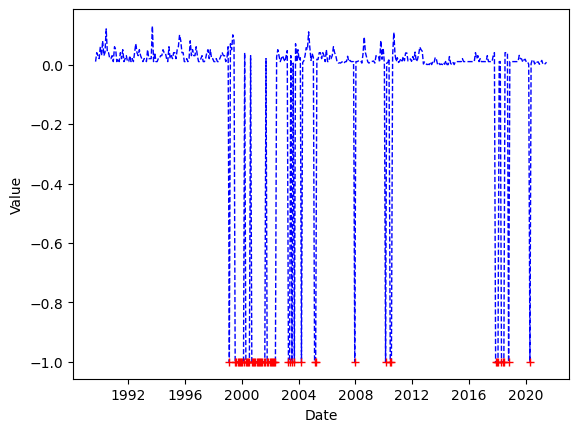

In [10]:
## Missing rows only
missing_rows = data_with_missing_replaced.loc[data_with_missing_replaced['missing'] == 1]
x = list(missing_rows.index)

## Plot the data including missing values
plt.plot(data_with_missing_replaced['date'], data_with_missing_replaced['value'], 'b--', lw=1.0)
plt.plot(missing_rows['date'], missing_rows['value'], 'r+', lw=1.0)
plt.ylabel('Value')
plt.xlabel('Date')
plt.show()

In [11]:
#CiSSA parameters
L = 12*8
data_per_year = 12

## Define error correction parameters
outliers = ['<',0]  #any value < -1 is an outlier/missing value
errors = ['value', 0.005]  #converge until error < 50
eigenvalue_proportion = 0.5 

In [12]:
## Apply cissa_outliers to check the reconstricted signal
## run pyCiSSA with outliers
x_ca, x_casa, rc = cissa_outlier(data_with_missing_replaced['value'],L,data_per_year,data_per_year,outliers = outliers,errors = errors, eigenvalue_proportion = eigenvalue_proportion)

Initial guess for outliers: [0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019
 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019
 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019
 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019
 0.019 0.019 0.019 0.019]
New points: [0.04174314 0.04597971 0.04273994 0.03189603 0.02074794 0.02020814
 0.02028611 0.01429249 0.01434284 0.02360324 0.02192633 0.02712374
 0.03078928 0.01891215 0.0199998  0.01727384 0.0119187  0.01558414
 0.02247421 0.02097324 0.01797118 0.02004413 0.01785187 0.01069139
 0.01185558 0.02332901 0.02474393 0.03074681 0.03138603 0.02203719
 0.01631464 0.01810273 0.01723455 0.02656153 0.02304865 0.02735634
 0.02712619 0.01163139 0.01638763 0.01901941 0.01488663 0.02202229
 0.02892182 0.03330994 0.02616549 0.02069368 0.017036   0.01458483
 0.02163475 0.0274304  0.02247943 0.00743689]
Consecutive prediction error: 0.026979713624913807 vs target

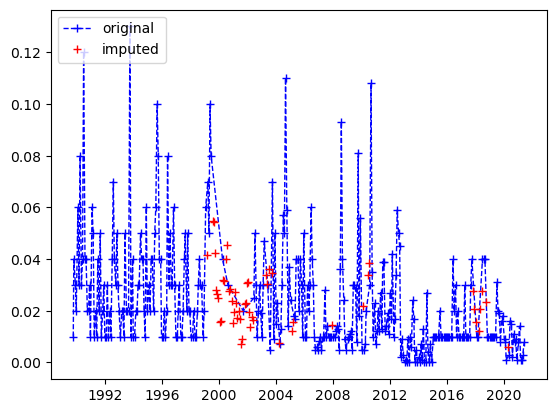

In [13]:

#plt.plot(data_with_missing_replaced['date'], data_with_missing_replaced['value'], 'b', lw=1.0, label = 'original')
plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--+', lw=1.0, label = 'original')
plt.plot(data_with_missing_replaced.loc[x,'date'], x_ca[x], 'r+', lw=1.0, label = 'imputed')
plt.legend(loc="upper left")

In [14]:
## Build grouping cell
Z,psd = cissa(x_ca,L)
period_ranges = {}
period_ranges.update({'long term cycle': [4,8]})
period_ranges.update({'seasonality': [0.9,1.1]})
period_ranges.update({'rapid': [0.1,0.5]})
I  = build_groupings(period_ranges,data_per_year,psd,Z,include_noise = True)
#2) Group components
rc, sh, kg = group(Z,psd,I)
print(sh)
print(kg)

{'long term cycle': 11.076981959255068, 'seasonality': 13.820722093728282, 'rapid': 37.505353312860805, 'trend': 12.193105493267074, 'noise': 25.01593704006938}
{'long term cycle': array([1, 2]), 'seasonality': array([7, 8]), 'rapid': array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]), 'trend': array([0]), 'noise': array([ 3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15])}


dict_keys(['long term cycle', 'seasonality', 'rapid', 'trend', 'noise'])


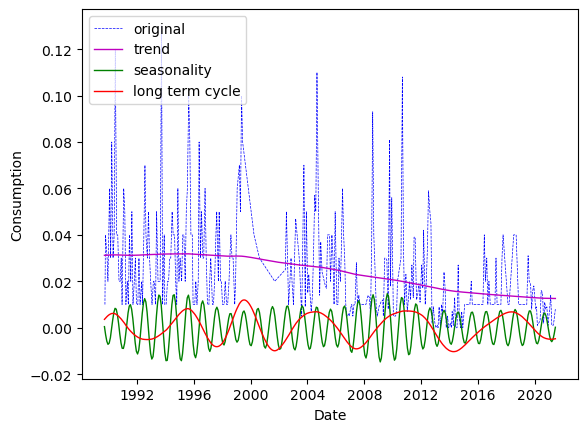

In [15]:
##plot trend, seasonality, long term cycle

print(rc.keys())

plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--', lw=0.5, label = 'original')
plt.plot(data_with_missing_replaced['date'], rc['trend'], 'm', lw=1.0, label = 'trend')
plt.plot(data_with_missing_replaced['date'], rc['seasonality'], 'g', lw=1.0, label = 'seasonality')
plt.plot(data_with_missing_replaced['date'], rc['long term cycle'], 'r', lw=1.0, label = 'long term cycle')
#plt.plot(data_with_missing_replaced['date'], rc['rapid'], 'k', lw=1.0, label = 'rapid')
#plt.plot(data_with_missing_replaced['date'], rc['noise'], 'k', lw=1.0, label = 'noise')
plt.legend(loc="upper left")
plt.ylabel('Consumption')
plt.xlabel('Date')
plt.show()

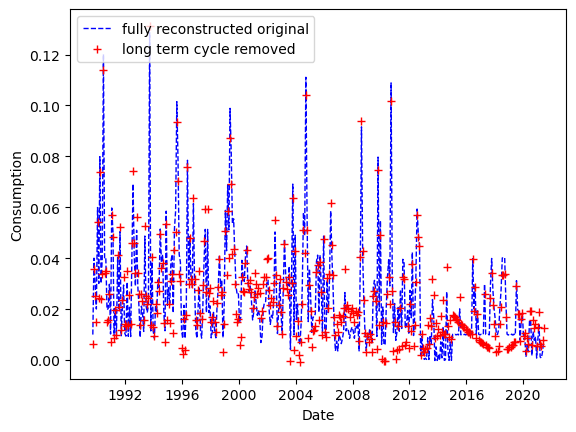

In [16]:
##plot data without long term cycle
rc_all = np.zeros(rc['trend'].shape)
rc_reduced = rc_all.copy()
for rc_i in rc.keys():
    rc_all += rc.get(rc_i)
    if not rc_i in ['long term cycle']:
        rc_reduced += rc.get(rc_i)

#plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--', lw=0.5, label = 'original')
plt.plot(data_with_missing_replaced['date'], rc_all, 'b--', lw=1.0, label = 'fully reconstructed original')
plt.plot(data_with_missing_replaced['date'], rc_reduced, 'r+', lw=1.0, label = 'long term cycle removed')
plt.legend(loc="upper left")
plt.ylabel('Consumption')
plt.xlabel('Date')
plt.show()


In [17]:
sh

{'long term cycle': 11.076981959255068,
 'seasonality': 13.820722093728282,
 'rapid': 37.505353312860805,
 'trend': 12.193105493267074,
 'noise': 25.01593704006938}